# Latent Y as Mu in Y_obs

Have $Y_{unobs}$ be the $\mu$ in $Y_{obs}$

This doesn't converge and is very likely just an incorrectly specified model

# Inputs

In [139]:
import rnaseq_lib3 as r
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt

import theano as tt

In [6]:
# Read in centered data
df = pd.read_hdf('/mnt/data/expression/tcga_gtex_tpm_norm_filt.hd5')
# Subset
gtex = df[df.label == 'gtex'].sort_values('tissue')
normal = df[df.label == 'tcga-normal'].sort_values('tissue')
tumor = df[df.label == 'tcga-tumor'].sort_values('tissue')
# Read in drug genes
genes = df.columns[5:]
drug_genes = [x.split('\t')[0] for x in open('../data/druggable-genes.tsv', 'r').readlines()]
drug_genes = [x for x in drug_genes if x in df.columns]

# Model Spec
Define inputs to model
- Sample
- Background dataset
- Training Genes

In [45]:
#tumor[tumor.tissue == 'Thyroid']
sample = tumor.loc['TCGA-FY-A3I4-01']

In [ ]:
sample = tumor.loc['TCGA-FY-A3I4-01']
print(f"Sample comes from tissue: {sample.tissue}")
# We'll pick a subset of normal tissue for model training
test = normal[normal.tissue.isin(['Thyroid', 'Prostate', 'Kidney', 'Liver'])]
training_genes = r.outlier.select_k_best_genes(test, genes, 'tissue', 10)
classes = sorted(test.tissue.unique())
ncats = len(classes)

In [211]:
with pm.Model() as model:
    # PRIORS
    a = pm.Normal('a', mu=0, sd=10)
    # Beta Coefficient
    mu_b = pm.Normal('mu_b', mu=0, sd=10)
    sigma_b = pm.InverseGamma('sigma_b', 2.1, 1)
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=ncats)
    
    # Means
    ymu = {}
    idx = test.tissue.astype('category').cat.codes
    for i, gene in enumerate(training_genes):
        ymu[gene] = pm.Normal(f'{gene}-Y-unobs', 0, 10, shape=ncats)
        
        # Define Y
        for j, dataset in enumerate(cats):
            pm.Normal(f'{gene}-Y-obs-{j}', ymu[gene][j], 10, observed=test[test.tissue == dataset][gene])
        
        # Define mu
        mu[gene] = pm.Deterministic(f'{gene}-Y', a + b[idx] * ymu[gene][idx])
    
    # Model estimation
    eps = pm.InverseGamma('eps', 2.1, 1)
    z = {}
    for gene in training_genes:
        z[gene] = pm.Laplace(gene, mu=mu[gene], b=eps, observed=sample[gene])

# Run Model

In [212]:
t0 = time.time()
with model:
    trace = pm.sample()
runtime = (time.time() - t0) / 60

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = -6,809.3:  21%|██▏       | 42893/200000 [02:35<09:09, 285.75it/s]
Convergence achieved at 42900
Interrupted at 42,899 [21%]: Average Loss = 6,420.4
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, APOB-Y-unobs, ASGR2-Y-unobs, HABP2-Y-unobs, AGXT-Y-unobs, ITIH1-Y-unobs, APCS-Y-unobs, C4BPB-Y-unobs, PLG-Y-unobs, APOH-Y-unobs, VTN-Y-unobs, sigma_y, mu_y, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 4000/4000 [37:45<00:00,  1.43s/draws]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.6835295370689706, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.7187502288665588, but shou

# Traceplot

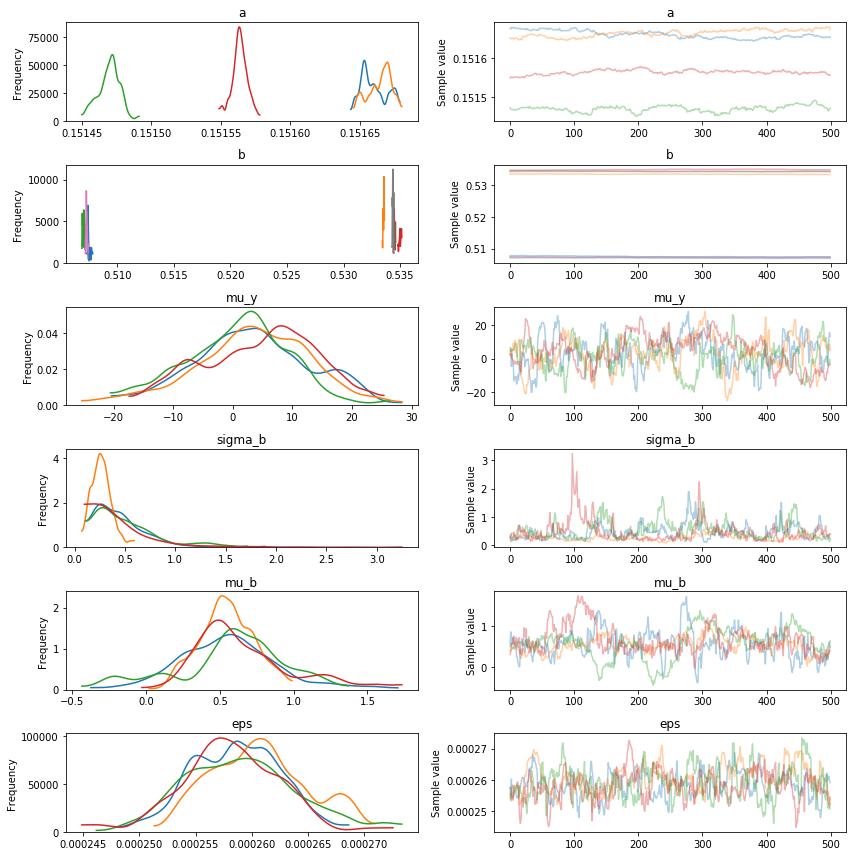

In [213]:
pm.traceplot(trace, varnames=['a', 'b', 'mu_y', 'sigma_b', 'mu_b', 'eps']);

# Model Weight

# PPC

In [214]:
ppc = pm.sample_ppc(trace=trace, model=model)

100%|██████████| 500/500 [00:10<00:00, 47.83it/s]


In [202]:
ppc.keys()

dict_keys(['VTN-Y-obs-0', 'VTN-Y-obs-1', 'APOH-Y-obs-0', 'APOH-Y-obs-1', 'PLG-Y-obs-0', 'PLG-Y-obs-1', 'C4BPB-Y-obs-0', 'C4BPB-Y-obs-1', 'APCS-Y-obs-0', 'APCS-Y-obs-1', 'ITIH1-Y-obs-0', 'ITIH1-Y-obs-1', 'AGXT-Y-obs-0', 'AGXT-Y-obs-1', 'HABP2-Y-obs-0', 'HABP2-Y-obs-1', 'ASGR2-Y-obs-0', 'ASGR2-Y-obs-1', 'APOB-Y-obs-0', 'APOB-Y-obs-1', 'VTN', 'APOH', 'PLG', 'C4BPB', 'APCS', 'ITIH1', 'AGXT', 'HABP2', 'ASGR2', 'APOB'])

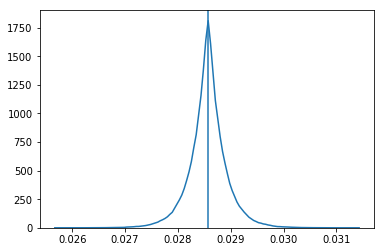

In [209]:
gene = 'AGXT'
plt.axvline(sample[gene])
sns.kdeplot(ppc[gene].ravel())

In [100]:
ppc = pm.sample_ppc(trace, model=model)

100%|██████████| 500/500 [00:08<00:00, 56.75it/s]
